**Łukasz Folwarczyk**

*"Badanie i implementacja algorytmów detekcji drogi przy wykorzystaniu cyfrowego przetwarzania obrazów."*

---

# Dataset miasto


Notatnik pozwalający na zapis obrazów przedstawiających drogi miejskie oraz ich etykiet (w formacie png) do pliku hdf5, który to wykorzystywany jest do procesu uczenia głębokiej sieci neuronowej (problem segmentacja). Działanie modułu opisane zostało w paragrafie 4.3.

In [1]:
%matplotlib inline
import os, sys
import cv2
import numpy as np
import PIL.Image
import time
import matplotlib.pyplot as plt
import math
from random import shuffle
from random import randint
import datetime
import h5py
timefunc = time.time

/home/lukasz/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def write_to_hdf5_file(hdf5_filename, 
                       img_label_pair, 
                       old_num_classes,
                       output_height,
                       output_width,
                       new_classes = None,
                       normalize = False, 
                       one_hot = True):
    """ 
    Opis:
    ---
    Funkcja pobiera jako argument listę krotek (img_label_pair) postaci:
    (ścieżka do obrazu, ścieżka do etykiety obrazu), wczytuję te obrazy 
    oraz ich etykiety i zapisuje do pojedynczego pliku wynikowego, z 
    rozszerzeniem hdf5. W zależnosci od pozostałych parametrów, 
    przed zapisem obrazy mogą zostać znormalizowane/zakodowane w formacje
    gorąco-jedynkowym (one-hot).
    
    Każdy plik zapisywnay jest w jednym z podkatalogów:
    imgs - obrazy oryginalne
    labels - etykiety
    vizs - wizualizacje
    
    Podkatalogi tworzone są w katalogu, którego nazwa stanowi argument 
    (output_dir) funkcji.
    
    Argumenty:
    ---
        hdf5_filename (string):   nazwa pliku wynikowego
        
        img_label_pair (list):    tablica krotek, zawierająca pary:
                                  (ścieżka obrazu, ścieżka etykiety)
        
        old_num_classes (int):    liczba klas w etykiecie
        
        output_height (int):      wysokosć obrazów/etykiet, zapisanych 
                                  w pliku wynikowym
        
        output_width (int):       szerokosć obrazów/etykiet, zapisanych 
                                  w pliku wynikowym
                                
        normalize (boolean):      normalizacja obrazów przed zapisem
        
        one_hot (boolean):        kodowanie gorąco-jedynkowe
        
        new_classes (dictionary): numer z którym związana jest klasa droga
                                  (w etykiecie)

    Return:
    ---
        None
    """
    try:
        with h5py.File(hdf5_filename) as hdf5_file:                   # otwarcie pliku hdf5
            dataset_len = len(img_label_pair)                         # wyznaczenie rozmiaru zbioru
            # pasek postępu
            toolbar_width = dataset_len // 10
            sys.stdout.write('[')
            sys.stdout.flush()
            counter = 1
            start = timefunc()                 
            
            img_type = np.asarray(PIL.Image.open(img_label_pair[0][0])).dtype # sprawdzenie typu obrazu 
            ann_type = np.asarray(PIL.Image.open(img_label_pair[0][1])).dtype # sprawdzenie typu etykiety

            
            # jeśli kodowanie gorąco-jedynkowe to etykieta wyjściowa posiadać będzie 
            # liczbę klas równą liczbie klas, przekazanych w parametrze new_classes + 1
            # np. jeśli podano {"road":1} to wwczas liczba klas = 2, 1 - droga, 
            #  2 - pozostałe klasy wystepujące w obrazie (zostaną połączone w jednką klase "tło" )  
            if one_hot and new_classes:
                num_cls = len(new_classes) + 1 
            else:
                num_cls = old_num_classes

            if one_hot:
                shape_label = (dataset_len, output_height*output_width, num_cls)
            else:
                shape_label = (dataset_len, output_height, output_width, num_cls)   
                
            shape_img = (dataset_len, output_height, output_width, 3) # ksztat zbioru "imgs" pliku hdf5
             
            hdf5_file.create_dataset("imgs", shape_img, np.uint8)     # zbiór pliku hdf5 przechowujący zdjęcia 
            hdf5_file.create_dataset("labels", shape_label, np.uint8) # zbiór pliku hdf5 przechowujący etykiety  
            hdf5_file.create_dataset("width", (1,), np.int16)         # zbiór pliku hdf5 przechowujący szerokość 
                                                                      # obrazów/etykiet
            hdf5_file.create_dataset("height", (1,), np.int16)        # zbiór pliku hdf5 przechowujący wysokość 
                                                                      # obrazów/etykiet
            hdf5_file.create_dataset("classes", (1,), np.int8)        # zbiór pliku hdf5 przechowujący
                                                                      # liczbę klas w etykiecie
            
            hdf5_file["width"][...] = output_width                    # zapisanie info. o szerokości 
                                                                      # (wspólna dla wszytskich zdjęć)
            hdf5_file["height"][...] = output_height                  # zapisanie info. o wysokości 
                                                                      # (wspólna dla wszytskich zdjęć)
            hdf5_file["classes"][...] = num_cls                       # zapisanie info. o ilosci klas
                                                                      # (wspólna dla wszytskich zdjęć)
            pair_counter = 0
            
            # wczytanie pary obraz/etykieta, ewentualne przetworzenie i zapisanie w pliku wynikowym hdf5            
            for img_path, label_path in img_label_pair:
                # pasek postępu
                if counter == round(toolbar_width / 3):
                    counter = 0
                    sys.stdout.write("=")
                    sys.stdout.flush()
                
                # wczytanie pary: obraz/etykieta
                img = np.asarray(PIL.Image.open(img_path))
                label = np.asarray(PIL.Image.open(label_path))
                
                # szerokość/wysokość pary wejściowej
                height = img.shape[0]
                width = img.shape[1]

                # szerokość/wysokość pary wyjściowej
                if (height != output_height) or (width != output_width):
                    img = cv2.resize(img, (output_width, output_height), 
                                           interpolation=cv2.INTER_NEAREST)
                    label = cv2.resize(label, (output_width, output_height), 
                                               interpolation=cv2.INTER_NEAREST)

                # normacja obrazu      
                if normalize:
                    img = normalize_img(img.astype(np.float32), img_type)

                image_label = None
                if one_hot:
                    # kodowanie gorąco-jedynkowe
                    label = label.reshape(output_height*output_width)
                    labels = np.zeros((output_height*output_width, 
                                       old_num_classes), 
                                      dtype=ann_type)
                    
                    j = np.arange(output_height*output_width)
                    labels[j, label] = 1
                    label = labels.reshape((output_height, 
                                            output_width, 
                                            old_num_classes))

                    # redukcja wymiarow
                    if not new_classes is None:
                        new_classes_len = len(new_classes) + 1
                        image_label = np.zeros(shape=(output_height, 
                                                      output_width, 
                                                      new_classes_len), 
                                                      dtype=ann_type)

                        # jezeli wszystkie klasy byly podne w jednym wymiarze to trzeba wiedziec jaki 
                        # nr ma droga ten numer jest w new_classes["road"]
                        cls = [i for i in range(old_num_classes)]

                        # stare i nowe klasy sa przedstawiane jako zbiory
                        # jezeli w zbiiorze 1 i 2 jest droga to dla niej zostanie stworzony nowy wymiar
                        # roznica w zbiorze to wszystkie pozostale klasy, ktore beda nalezaly do jednego wymiaru
                        old_classes = set(cls)
                        new_classes_set = set()
                        
                        if "road" in new_classes:
                            road_index = new_classes["road"]
                            image_label[:,:,0] = label[:,:,road_index]
                            new_classes_set.add(road_index)

                        old_classes = old_classes.difference(new_classes_set)

                        for i in old_classes:
                            image_label[:,:,1] += label[:,:,i] 

                        image_label = image_label
                        number_of_classes = new_classes_len
                    else:
                        image_label = label
                        number_of_classes = old_num_classes               

                    image_label = image_label.reshape(output_height*output_width, 
                                                      number_of_classes)

                # zapisanie pary obraz/etykieta do pliku    
                hdf5_file["imgs"][pair_counter, ...] = img[None]
                hdf5_file["labels"][pair_counter, ...] = image_label[None]
                
                pair_counter += 1
                counter += 1                  
            # pasek postępu
            elapsed = timefunc() - start
            sys.stdout.write(']\n')
            sys.stdout.flush()
            print("---------------------------".format(dataset_len))
            print("Czas kompresji: {:.3f}".format(elapsed))

    except:
        print("[ERROR] Nieoczekiwany błąd ({})".format(sys.exc_info()[1]))
    

In [3]:
def write_to_hdf5_file_test(hdf5_filename, 
                          imgs, 
                          output_height,
                          output_width,
                          normalize = False):
    """ 
    Opis:
    ---
    Funkcja zapisuje obrazy (z rozszerzeniem png) do pliku hdf5, 
    może zostać wykorzystana wyłącznie do zbioru testowego, ponieważ
    nie zapisuje etykiet.
    
    Argumenty:
    ---
        hdf5_filename (string):   nazwa pliku wynikowego
        
        imgs (list):              tablica ścieżek do obrazów
        
        output_height (int):      wysokosć obrazów, zapisanych 
                                  w pliku wynikowym
        
        output_width (int):       szerokosć obrazów, zapisanych 
                                  w pliku wynikowym
                                
        normalize (boolean):      normalizacja obrazów przed zapisem
        
    Return:
    ---
        None
    """
    try:
        with h5py.File(hdf5_filename) as hdf5_file:                 
            dataset_len = len(imgs)
            toolbar_width = dataset_len // 10
            # pasek postępu
            sys.stdout.write('[')
            sys.stdout.flush()
            counter = 1
            start = timefunc()                 
            
            img_type = np.asarray(PIL.Image.open(imgs[0])).dtype       # sprawdzenie typu obrazu 
            shape_img = (dataset_len, output_height, output_width, 3)
        
            hdf5_file.create_dataset("imgs", shape_img, np.uint8)      # zbiór pliku hdf5 przechowujący zdjęcia 
            hdf5_file.create_dataset("width", (1,), np.int16)          # zbiór pliku hdf5 przechowujący szerokość 
            hdf5_file.create_dataset("height", (1,), np.int16)         # zbiór pliku hdf5 przechowujący wysokość 
            
            hdf5_file["width"][...] = output_width                     # zapisanie info. o szerokości
                                                                       # (wspólna dla wszytskich zdjęć)
            hdf5_file["height"][...] = output_height                   # zapisanie info. o wysokości
                                                                       # (wspólna dla wszytskich zdjęć)
            
            pair_counter = 0
            # wczytanie obrazu, ewentualne przetworzenie i zapisanie w pliku wynikowym hdf5
            for img_path in imgs:
                # pasek postępu
                if counter == round(toolbar_width / 3):
                    counter = 0
                    sys.stdout.write("=")
                    sys.stdout.flush()
                # wczytanie obrazu
                img = cv2.imread(img_path)
                
                # szerokość/wysokość obrazu wejściowego
                height = img.shape[0]
                width = img.shape[1]

                # szerokość/wysokość obrazu wyjściowego
                if (height != output_height) or (width != output_width):
                    img = cv2.resize(img, (output_width, output_height), 
                                           interpolation=cv2.INTER_NEAREST)
                    
                img = np.asarray(img)
                
                # normacja obrazu 
                if normalize:
                    img = normalize_img(img.astype(np.float32), img_type)
                
                # zapisanie obrazu do pliku
                hdf5_file["imgs"][pair_counter, ...] = img[None]

                pair_counter += 1
                counter += 1                  
            # pasek postępu
            elapsed = timefunc() - start
            sys.stdout.write(']\n')
            sys.stdout.flush()
            print("Czas kompresji: {:.3f}".format(elapsed))

    except:
        print("[ERROR] Nieoczekiwany błąd ({})".format(sys.exc_info()[0]))
    

In [4]:
def display_img_batch(hdf5_filename, 
                      dataset_img, 
                      dataset_label, 
                      one_hot, 
                      batch_size, 
                      class_index):  
    """ 
    Opis:
    ---
    Funkcja wyświetla przykładowe obrazy oraz ich etykiety, 
    zapisane w pliku z rozszerzeniem hdf5.
    
    Argumenty:
    ---
        hdf5_filename (string):   nazwa pliku wynikowego
        
        dataset_img (string):     nazwa zbioru pliku hdf5, 
                                  w którym zapisane sa obrazy
        
        dataset_label (string):   nazwa zbioru pliku hdf5, 
                                  w którym zapisane sa etykiety
        
        one_hot (boolean):        kodowanie gorąco-jedynkowe
                                                                  
        batch_size (int):         ilosć wyświetlonych próbek
        
        class_index (int):        numer klasy wyróżnionej na zdjęciu
    
    Return:
    ---
        None
    """
    
    with h5py.File(hdf5_filename) as hdf_file_read:                  # otwarcie pliku hdf5
        height = hdf_file_read["height"][0, ...]                     # odczytanie wysokosci obrazów/etykiet
        width = hdf_file_read["width"][0, ...]                       # odczytanie szerokoci obrazów/etykiet
        cls =  hdf_file_read["classes"][0, ...]                      # odczytanie ilości klas w etykietach
        dataset_len = hdf_file_read[dataset_img].shape[0]            # odczytanie ilości par obraz/etykieta
        
        # wyświetlenie par obraz/etykieta (ilość zależna od parametru batch_size)
        for i in range(batch_size):
            # zostaje wyświetlona losowa para
            rand = randint(0, dataset_len)
            
            # odtworzenie obrazu / etykiety
            reconstructed_img = (hdf_file_read[dataset_img][rand:min(rand+1,dataset_len), ...])
            reconstructed_img = reconstructed_img[0,:,:,:]
            img_shape = reconstructed_img.shape
            reconstructed_label = (hdf_file_read[dataset_label][rand:min(rand+1,dataset_len), ...])
            
            # przetworzenie etykiety w zalezności od kodowania
            if one_hot:
                reconstructed_label = reconstructed_label[0,:,:]
                label_shape = reconstructed_label.shape
                reconstructed_label = reconstructed_label.reshape(height,width,cls)
            else:
                reconstructed_label = reconstructed_label[0,:,:,:]
                label_shape = reconstructed_label.shape
             
            # wyświetlenie pary obraz/etykieta
            fig = plt.figure()
            fig.add_subplot(1, 2, 1)
            plt.imshow(reconstructed_img)
            fig.add_subplot(1, 2, 2)
            plt.imshow(reconstructed_label[:,:,class_index])
    print("---------------------------".format(dataset_len))
    print("Ilość obrazów w zbiorze: {}".format(dataset_len))
    print("Kształt obrazów: {}".format(img_shape))
    print("Kształt etykiet: {}".format(label_shape))

In [5]:
def normalize_img(image, image_type):
    """ 
    Opis:
    ---
    Funkcja normalizująca obraz.
    
    Argumenty:
    ---
        image (numpy.ndarray):    obraz wejściowy
        
        image_type (numpy.dtype): typ obrazu wejściowego
    
    Return:
    ---
        image (numpy.ndarray):    obraz znormalizowany
    """

    mean = image.mean()
    image = image - mean
    image /= (image.std() + 1e-5)
    image *= 0.1
    image += 0.5
    image = np.clip(image, 0, 1)
    image *= 255
    image = image.astype(image_type)
    return image

In [6]:
def calculate_number_of_classess(img_lab_pair):
    """ 
    Opis:
    ---
    Funkcja wyznaczajaca ilosć klas w etykiecie, 
    przy założeniu że wszystkie etykiety związane są z 3 wymiarem
    np. (szerkosci,wysokość,1) - z 3 wymiarem związane są wszystkie klasy,
    każdy piksel etykiety o wspólrzędnych (x, y) może mieć wartość 
    0,1,2...ilosć klas. 
    
    Argumenty:
    ---
        image (numpy.ndarray):    obraz wejściowy
        
        image_type (numpy.dtype): typ obrazu wejściowego
    
    Return:
    ---
        image (numpy.ndarray):    obraz znormalizowany
    """
    num_classes = 0
    num_classes_max = 0
    classes_set = set()
    for img_path, label_path in img_lab_pair:
        label = np.asarray(PIL.Image.open(label_path))
        num_classes = max(classes_set.union(set(np.unique(label))))
        if num_classes > num_classes_max:
            num_classes_max = num_classes
    return (num_classes_max + 1)

# Przykład

In [7]:
# katalogi ze zdjęciami 
dataset_path = '../../Dataset/'

# katalogi ze zdjęciami oraz etykietami dla zbioru treningowego
images_train_dir =  dataset_path + 'miasto_dataset/train/imgs'
labels_train_dir =  dataset_path + 'miasto_dataset/train/labels'

# katalogi ze zdjęciami oraz etykietami dla zbioru walidacyjnego
images_eval_dir = dataset_path + 'miasto_dataset/valid/imgs'
labels_eval_dir = dataset_path + 'miasto_dataset/valid/labels'

# katalogi ze zdjęciami oraz etykietami dla zbioru testowego
images_test_dir = dataset_path + 'miasto_dataset/test/imgs'
labels_test_dir = dataset_path + 'miasto_dataset/test/labels'

hdf5_files_path = os.getcwd() + '/' + 'hdf5'
if not os.path.exists(hdf5_files_path):
    os.makedirs(hdf5_files_path)
    
hdf5_filename_train = hdf5_files_path + '/' + 'miasto_dataset_train.hdf5'
hdf5_filename_eval = hdf5_files_path + '/' + 'miasto_dataset_eval.hdf5'
hdf5_filename_test = hdf5_files_path + '/' + 'miasto_dataset_test.hdf5'

if os.path.isfile(hdf5_filename_train):
    os.remove(hdf5_filename_train)
    
if os.path.isfile(hdf5_filename_eval):
    os.remove(hdf5_filename_eval) 

if os.path.isfile(hdf5_filename_test):
    os.remove(hdf5_filename_test)

In [8]:
# Zbiór treningowy
# Sprawdzenie czy nazwy plików (png) w katalogu obrazów są zgodne z nazwami plików (png) w katalogu etykiet. 

images_train = os.listdir(images_train_dir)
labels_train = os.listdir(labels_train_dir)


if not set(images_train) == set(labels_train):
    print("[INFO] Zbiór obrazow treningowy nie jest zgodny z odpowiadającym mu zbiorem etykiet")
else:
    print("[INFO] Zbiór obrazow treningowy jest zgodny z odpowiadającym mu zbiorem etykiet")
assert set(images_train) == set(labels_train)

[INFO] Zbiór obrazow treningowy jest zgodny z odpowiadającym mu zbiorem etykiet


In [9]:
# Zbiór walidacyjny
# Sprawdzenie czy nazwy plików (png) w katalogu obrazów są zgodne z nazwami plików (png) w katalogu etykiet.

images_eval = os.listdir(images_eval_dir)
labels_eval  = os.listdir(labels_eval_dir)

if not set(images_eval) == set(labels_eval):
    print("[INFO] Zbiór obrazow walidacyjnych nie jest zgodny z odpowiadającym mu zbiorem etykiet")
else:
    print("[INFO] Zbiór obrazow walidacyjnych jest zgodny z odpowiadającym mu zbiorem etykiet")
assert set(images_eval) == set(labels_eval)

[INFO] Zbiór obrazow walidacyjnych jest zgodny z odpowiadającym mu zbiorem etykiet


In [10]:
# Zbiór testowy
# Sprawdzenie czy nazwy plików (png) w katalogu obrazów są zgodne z nazwami plików (png) w katalogu etykiet.

images_test = os.listdir(images_test_dir)
labels_test  = os.listdir(labels_test_dir)

if not set(images_test) == set(labels_test):
    print("[INFO] Zbiór obrazow testowych nie jest zgodny z odpowiadającym mu zbiorem etykiet")
else:
    print("[INFO] Zbiór obrazow testowych jest zgodny z odpowiadającym mu zbiorem etykiet")
assert set(images_test) == set(labels_test)

[INFO] Zbiór obrazow testowych jest zgodny z odpowiadającym mu zbiorem etykiet


In [11]:
# Zbiór testowy
# Stworzenie tablicy krotek, zawierających parę (ścieżka obrazu, ścieżka etykiety)

image_label_pair_train = [(images_train_dir + '/' + i, labels_train_dir + '/' + j) 
                for i in images_train for j in labels_train if i == j]

np.random.shuffle(image_label_pair_train)

image_label_pair_train_len = len(image_label_pair_train)

print("[INFO] Ilosc próbek w zbiorze treningowym: {}".format(image_label_pair_train_len))

[INFO] Ilosc próbek w zbiorze treningowym: 595


In [12]:
# Zbiór walidacyjny
# Stworzenie tablicy krotek, zawierających parę (ścieżka obrazu, ścieżka etykiety)

image_label_pair_eval = [(images_eval_dir + '/' + i, labels_eval_dir + '/' + j) 
                for i in images_eval for j in labels_eval if i == j]

np.random.shuffle(image_label_pair_eval)

image_label_pair_eval_len = len(image_label_pair_eval)
print("[INFO] Ilosc obrazow w zbiorze walidacyjnym: {}".format(image_label_pair_eval_len))

[INFO] Ilosc obrazow w zbiorze walidacyjnym: 85


In [13]:
# Zbiór testowy
# Stworzenie tablicy krotek, zawierających parę (ścieżka obrazu, ścieżka etykiety)

image_label_pair_test = [(images_test_dir + '/' + i, labels_test_dir + '/' + j) 
                for i in images_test for j in labels_test if i == j]

np.random.shuffle(image_label_pair_test)

image_label_pair_test_len = len(image_label_pair_test)
print("[INFO] Ilosc obrazow w zbiorze testowym: {}".format(image_label_pair_test_len))

[INFO] Ilosc obrazow w zbiorze testowym: 170


In [14]:
# Ilość klas w etykiecie
number_of_classes_in_labels = calculate_number_of_classess(image_label_pair_eval)

# Rozmiar wyjściowy obrazów oraz etykiet
image_out_height = 200
image_out_width = 300

(1024, 2048)
[[7 7 7 ... 7 7 7]
 [7 7 7 ... 7 7 7]
 [7 7 7 ... 7 7 7]
 ...
 [7 7 7 ... 7 7 7]
 [7 7 7 ... 7 7 7]
 [7 7 7 ... 7 7 7]]


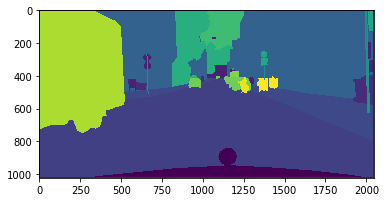

In [15]:
ann_type = np.asarray(PIL.Image.open(image_label_pair_train[0][1]))
plt.imshow(ann_type)
print(ann_type.shape)
print(ann_type[750:850,750:850])

In [16]:
# Klasy w etykiecie wyjściowej, w tym przypadku etykieta będzie miała wymiar
# (szerokosć, wysokość, 2), gdzie jeden z wymiarów reprezentowac będzie piksele należące do klasy "road", 
# drugi pozostałe piksele występujące w obrazie (klasyfikowane domyślnie jako tło)
# w tym przypadku pikselom należącym do drogi w etykiecie wejściowej odpowiada wartość 7 (jak pokazano powyżej)
cls = {"road":7}

In [17]:
# Zapisanie do pliku hdf5 zbioru treningowego
write_to_hdf5_file(hdf5_filename_train, 
                   image_label_pair_train,
                   output_height = image_out_height,
                   output_width = image_out_width, 
                   old_num_classes = number_of_classes_in_labels,
                   new_classes = cls,
                   normalize = True)

[=============================]
---------------------------
Czas kompresji: 68.090


---------------------------
Ilość obrazów w zbiorze: 595
Kształt obrazów: (200, 300, 3)
Kształt etykiet: (60000, 2)


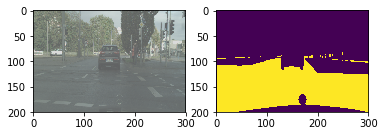

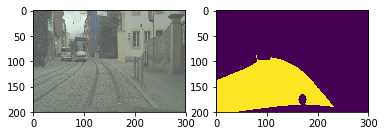

In [18]:
# Zbiór treningowy
# Wyświetlenie przykładowych par ze stworzonego pliku hdf5
display_img_batch(hdf5_filename_train, 
                  "imgs", 
                  "labels", 
                  batch_size = 2,
                  one_hot = True,
                  class_index = 0)

In [19]:
# Zapisanie do pliku hdf5 zbioru walidacyjnego
write_to_hdf5_file(hdf5_filename_eval, 
                   image_label_pair_eval,
                   output_height = image_out_height,
                   output_width = image_out_width, 
                   old_num_classes = number_of_classes_in_labels,
                   new_classes = cls,
                   normalize = True)

[============================]
---------------------------
Czas kompresji: 12.476


---------------------------
Ilość obrazów w zbiorze: 85
Kształt obrazów: (200, 300, 3)
Kształt etykiet: (60000, 2)


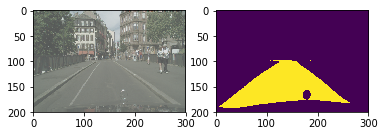

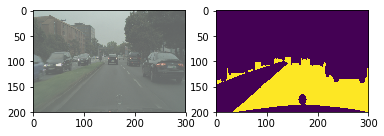

In [20]:
# Zbiór walidacyjny
# Wyświetlenie przykładowych par ze stworzonego pliku hdf5
display_img_batch(hdf5_filename_eval, 
                  "imgs", 
                  "labels", 
                  batch_size = 2, 
                  one_hot = True,
                  class_index = 0)

In [21]:
# Zapisanie do pliku hdf5 zbioru testowego
write_to_hdf5_file(hdf5_filename_test, 
                   image_label_pair_test,
                   output_height = image_out_height,
                   output_width = image_out_width, 
                   old_num_classes = number_of_classes_in_labels,
                   new_classes = cls,
                   normalize = True)

[============================]
---------------------------
Czas kompresji: 26.107


---------------------------
Ilość obrazów w zbiorze: 170
Kształt obrazów: (200, 300, 3)
Kształt etykiet: (60000, 2)


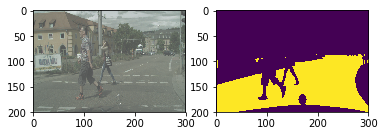

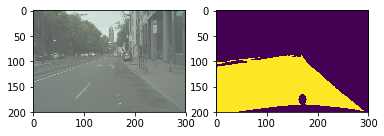

In [22]:
# Zbiór testowy
# Wyświetlenie przykładowych par ze stworzonego pliku hdf5
display_img_batch(hdf5_filename_test, 
                  "imgs", 
                  "labels", 
                  batch_size = 2, 
                  one_hot = True,
                  class_index = 0)